# Getting Started 🚀

## Prerequisites

Before diving into the code, please ensure you:

1. 📖 Read the `README.md` file for:
   - Project setup instructions
   - Environment configuration
   - Dependency installation
   - Basic usage guidelines

2. 📑 Review the attached PDF documentation for:
   - Detailed code explanations
   - Technical implementation details
   - Architectural decisions
   - Performance considerations

## Quick Setup Guide

### 1. Project Setup
```bash
# Install dependencies
pip install -r requirements.txt
```

### 2. Documentation
- 📚 `README.md`: Project setup and basic usage
- 📄 PDF Guide: In-depth technical documentation
- 💻 Code Comments: Implementation details


In [5]:
import os
import glob
import nibabel as nib
import pandas as pd
import numpy as np
from nilearn import plotting
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from nilearn.image import load_img, resample_img
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

Let's first take a look at a brain scan to ensure you have imported the appropriate data and that your project is configured correctly. You should see a 3 panel view of a brain scan and you should be able to scan through slices of the images by clicking on a cursor and moving it around.

/Users/nolanbetts/.pyenv/versions/3.12.0/envs/assignment5/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



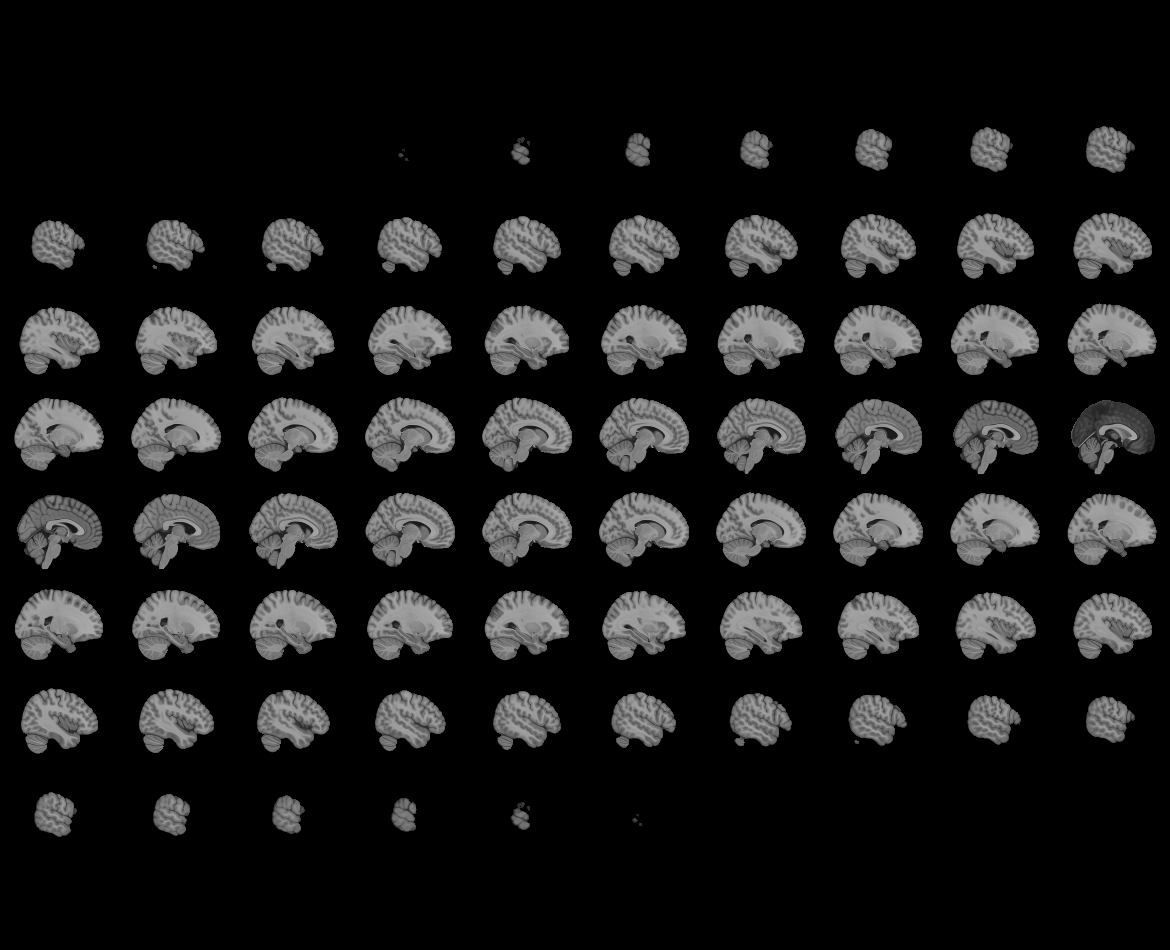
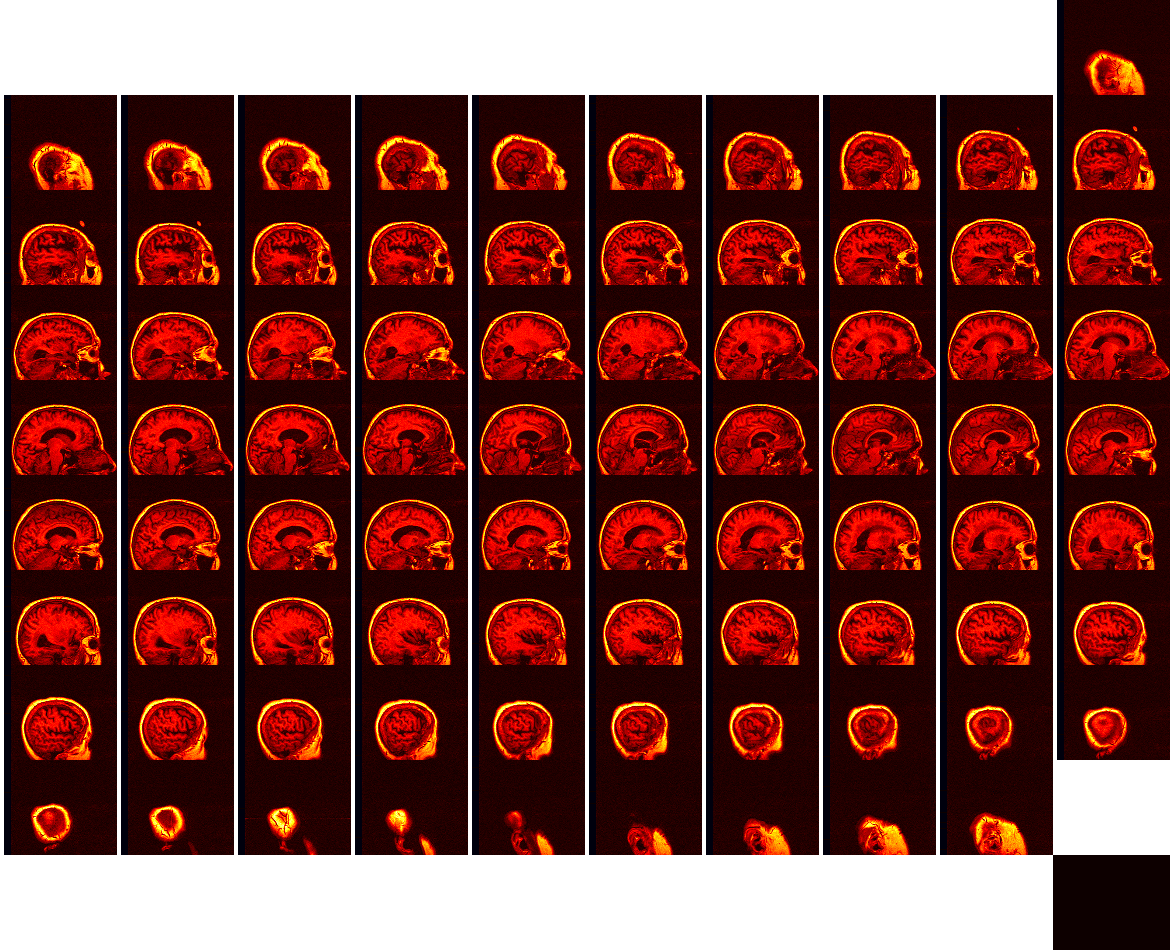

In [25]:
img = nib.load('data/OAS2_RAW_PART1/OAS2_0099_MR2/RAW/mpr-1.nifti.img')
plotting.view_img(img, title='MPR', threshold=None)

# Loading the Data 🧠

## Overview
This section handles the crucial process of loading and preprocessing MRI data from our data directory. The process includes careful tracking of patient-scan relationships and efficient data resampling.

## Key Features

### 📊 Data Management
- Loads MRI scans from the data directory
- Maintains patient-scan relationships
- Resamples images to consistent dimensions
- Tracks demographic information

### 🔄 Processing Steps
1. Load raw MRI scans
2. Resample to standardized dimensions
3. Link scans with patient IDs
4. Normalize image data
5. Prepare for model input

### ⏱️ Performance Considerations
- Loading process takes approximately 10-15 minutes
- Progress bar implementation shows:
  - Current loading status
  - Estimated time remaining
  - Number of processed scans

## Quality Assurance
- ✓ Consistent image dimensions
- ✓ Proper patient-scan mapping
- ✓ Progress monitoring
- ✓ Error handling
- ✓ Memory efficiency

## Output
- Preprocessed MRI scans
- Patient ID mappings
- Demographic information
- Data quality metrics

---
*Note: The loading process is optimized for both accuracy and efficiency while maintaining data integrity.*

In [7]:
def load_data():
    # Read the demographics file
    df = pd.read_csv('data/oasis_longitudinal_demographics-8d83e569fa2e2d30.csv')
    
    # Initialize lists to store data
    images = []
    ages = []  # Store ages instead of dementia labels
    patient_ids = []  # Track patient IDs for proper splitting
    
    print("Loading brain scans...")
    
    # Define parts to load from
    parts = ['OAS2_RAW_PART1', 'OAS2_RAW_PART2']
    
    # Track age statistics
    all_ages = []
    
    # Track number of images per patient
    patient_image_counts = {}
    
    # First, count total number of potential images
    total_images = 0
    for _, row in df.iterrows():
        for part in parts:
            base_path = os.path.join('data', part, row['MRI ID'], 'RAW')
            if os.path.exists(base_path):
                mpr_pattern = os.path.join(base_path, 'mpr-*.nifti.img')
                total_images += len(glob.glob(mpr_pattern))
    
    # Create progress bar
    pbar = tqdm(total=total_images, desc='Loading images', unit='scan')
    loaded_count = 0
    
    # Iterate through each row in the demographics file
    for idx, row in df.iterrows():
        try:
            # Try both parts
            for part in parts:
                base_path = os.path.join('data', part, row['MRI ID'], 'RAW')
                
                if not os.path.exists(base_path):
                    continue
                
                # Find all MPR images for this patient
                mpr_pattern = os.path.join(base_path, 'mpr-*.nifti.img')
                mpr_files = sorted(glob.glob(mpr_pattern))
                
                for img_path in mpr_files:
                    try:
                        # Load and preprocess image
                        img = nib.load(img_path)
                        img.set_sform(img.get_qform())
                        # Create a proper 4x4 affine matrix
                        target_shape = (64, 64, 64)
                        target_affine = np.eye(4)
                        target_affine[0:3, 0:3] = np.diag([4., 4., 4.])
                        
                        # Resample image
                        img_resampled = resample_img(img, 
                                                   target_affine=target_affine,
                                                   target_shape=target_shape,
                                                   force_resample=True,
                                                   copy_header=True)
                        
                        # Get image data as numpy array
                        img_data = img_resampled.get_fdata()
                        
                        # Normalize image data
                        img_data = (img_data - img_data.mean()) / img_data.std()
                        
                        # Add channel dimension at the beginning
                        img_data = np.expand_dims(img_data, axis=0)
                        img_data = img_data.reshape(1, 64, 64, 64)
                        
                        # Get age
                        age = float(row['Age'])
                        
                        images.append(img_data)
                        ages.append(age)
                        patient_ids.append(row['MRI ID'])
                        all_ages.append(age)
                        
                        # Track images per patient
                        patient_id = row['MRI ID']
                        patient_image_counts[patient_id] = patient_image_counts.get(patient_id, 0) + 1
                        
                        # Update progress
                        loaded_count += 1
                        pbar.update(1)
                        pbar.set_postfix({'Loaded': f'{loaded_count}/{total_images}'})
                        
                    except Exception as e:
                        print(f"\nError loading {img_path}: {str(e)}")
                
                if len(mpr_files) > 0:
                    break  # Found images for this patient, move to next
                
        except Exception as e:
            print(f"\nError processing {row['MRI ID']}: {str(e)}")
    
    # Close progress bar
    pbar.close()
    
    # Stack all images
    print("\nProcessing loaded images...")
    images = np.stack(images)
    ages = np.array(ages)
    patient_ids = np.array(patient_ids)
    
    # Normalize ages to have zero mean and unit variance
    age_mean = np.mean(ages)
    age_std = np.std(ages)
    ages_normalized = (ages - age_mean) / age_std
    
    print(f"\nFinal images shape: {images.shape}")
    print(f"Number of unique subjects: {len(set(patient_ids))}")
    print(f"Total number of images: {len(ages)}")
    print("\nAge statistics:")
    print(f"Min age: {np.min(ages):.1f}")
    print(f"Max age: {np.max(ages):.1f}")
    print(f"Mean age: {np.mean(ages):.1f}")
    print(f"Std age: {np.std(ages):.1f}")
    
    # Print distribution of images per patient
    image_counts = list(patient_image_counts.values())
    print("\nImages per patient statistics:")
    print(f"Min: {min(image_counts)}")
    print(f"Max: {max(image_counts)}")
    print(f"Mean: {sum(image_counts)/len(image_counts):.2f}")
    
    return images, ages_normalized, patient_ids, (age_mean, age_std)

# Splitting the Data

## Purpose
We split the data into training and test sets using `GroupShuffleSplit` to ensure the model's integrity and prevent data leakage.

## Implementation Details

### Why Group-Based Splitting?
To prevent the model from "cheating" by memorizing individual brain patterns, we ensure that:
- All scans from a single patient appear in either training OR test set, never both
- This prevents the model from learning patient-specific features
- Results in more realistic and generalizable performance metrics

### Technical Implementation
```python
splitter = GroupShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)
train_idx, test_idx = next(splitter.split(
    images,
    ages_normalized,
    groups=patient_ids
))
```

### Data Distribution
- Training set: 80% of patients
- Test set: 20% of patients
- Each patient's complete set of scans stays together

## Benefits
- ✓ Prevents data leakage
- ✓ More realistic evaluation metrics
- ✓ Better model generalization
- ✓ Robust cross-patient performance

This approach ensures that our model learns generalizable features of brain aging rather than memorizing individual patient characteristics.

In [8]:
# First, load the data
print("Loading data...")
images, ages_normalized, patient_ids, (age_mean, age_std) = load_data()

# Split the data using GroupShuffleSplit to prevent data leakage
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(images, ages_normalized, groups=patient_ids))

X_train, X_test = images[train_idx], images[test_idx]
y_train, y_test = ages_normalized[train_idx], ages_normalized[test_idx]

print(f"Training set size: {len(X_train)} (from {len(set(patient_ids[train_idx]))} patients)")
print(f"Test set size: {len(X_test)} (from {len(set(patient_ids[test_idx]))} patients)")

Loading data...
Loading brain scans...


Loading images: 100%|██████████| 1367/1367 [09:26<00:00,  2.42scan/s, Loaded=1367/1367]



Processing loaded images...

Final images shape: (1367, 1, 64, 64, 64)
Number of unique subjects: 373
Total number of images: 1367

Age statistics:
Min age: 60.0
Max age: 98.0
Mean age: 77.0
Std age: 7.6

Images per patient statistics:
Min: 2
Max: 4
Mean: 3.66
Training set size: 1092 (from 298 patients)
Test set size: 275 (from 75 patients)


<div align="center">

# 🧠 BrainAgeDataset Class

*Advanced data handling and augmentation for MRI-based age prediction*

</div>

---

## 📋 Overview

The `BrainAgeDataset` class serves as a crucial component in our deep learning pipeline, managing MRI data processing and augmentation for robust age prediction.

## 🎯 Key Objectives

- Standardize MRI data preprocessing
- Implement real-world data augmentation
- Enhance model generalization
- Ensure consistent data formatting

## 🛠️ Core Functionality

<table>
  <tr>
    <th width="200">Feature</th>
    <th>Description</th>
  </tr>
  <tr>
    <td><b>📊 Data Loading</b></td>
    <td>Efficient loading and preprocessing of brain MRI scans</td>
  </tr>
  <tr>
    <td><b>🔄 Augmentation</b></td>
    <td>Real-world scenario simulation through various transformations</td>
  </tr>
  <tr>
    <td><b>⚙️ Preprocessing</b></td>
    <td>Standardization and normalization of input data</td>
  </tr>
  <tr>
    <td><b>🎛️ Format Control</b></td>
    <td>Ensures compatibility with neural network requirements</td>
  </tr>
</table>

## 💫 Data Augmentation Techniques

### Real-World Simulations

| Technique | Purpose | Implementation |
|-----------|---------|----------------|
| **Random Noise** | Simulate scanner variations | Gaussian noise addition |
| **Intensity Shifts** | Account for contrast differences | Random scaling |
| **Flipping** | Increase spatial diversity | Horizontal mirroring |

## 🎯 Benefits

<div style="display: flex; justify-content: space-between;">
  <div style="flex: 1; padding: 10px;">
    <h3>🔍 Improved Generalization</h3>
    <ul>
      <li>Better performance on unseen data</li>
      <li>Reduced overfitting</li>
      <li>Robust to variations</li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px;">
    <h3>📈 Enhanced Training</h3>
    <ul>
      <li>Larger effective dataset</li>
      <li>Better feature learning</li>
      <li>Stable convergence</li>
    </ul>
  </div>
</div>

In [9]:
class BrainAgeDataset(Dataset):
    """
    Custom PyTorch Dataset for brain MRI scans and age prediction.
    
    This class handles the loading and preprocessing of brain MRI scans for age prediction.
    It includes data augmentation techniques for training and ensures proper data formatting
    for the neural network.
    
    Attributes:
        images (torch.FloatTensor): Preprocessed MRI scans
        ages (torch.FloatTensor): Corresponding age labels
        is_train (bool): Flag indicating if this is for training (enables augmentation)
    """
    
    def __init__(self, images, ages, is_train=True):
        """
        Initialize the dataset.
        
        Args:
            images (numpy.ndarray): Preprocessed MRI scans
            ages (numpy.ndarray): Age labels
            is_train (bool): Whether this dataset is for training (default: True)
        """
        self.images = torch.FloatTensor(images)
        self.ages = torch.FloatTensor(ages)
        self.is_train = is_train
    
    def random_noise(self, image, noise_factor=0.05):
        """
        Add random Gaussian noise to the image for data augmentation.
        
        Args:
            image (torch.Tensor): Input image
            noise_factor (float): Standard deviation of the noise (default: 0.05)
            
        Returns:
            torch.Tensor: Image with added noise
        """
        noise = torch.randn_like(image) * noise_factor
        return image + noise
    
    def random_intensity(self, image, factor_range=0.2):
        """
        Randomly adjust image intensity for data augmentation.
        
        Args:
            image (torch.Tensor): Input image
            factor_range (float): Range for intensity adjustment (default: 0.2)
            
        Returns:
            torch.Tensor: Intensity-adjusted image
        """
        factor = 1.0 + torch.rand(1).item() * factor_range - factor_range/2
        return image * factor
    
    def random_flip(self, image):
        """
        Randomly flip the image horizontally for data augmentation.
        
        Args:
            image (torch.Tensor): Input image
            
        Returns:
            torch.Tensor: Potentially flipped image
        """
        if torch.rand(1).item() > 0.5:
            return torch.flip(image, dims=[3])  # Flip along width
        return image
    
    def __len__(self):
        """
        Get the total number of samples in the dataset.
        
        Returns:
            int: Number of samples
        """
        return len(self.images)
    
    def __getitem__(self, idx):
        """
        Get a sample from the dataset.
        
        During training, applies random augmentations with 50% probability each:
        - Random noise addition
        - Random intensity adjustment
        - Random horizontal flip
        
        Args:
            idx (int): Index of the sample to retrieve
            
        Returns:
            tuple: (image, age) where image is the processed MRI scan and age is the target
        """
        image = self.images[idx]
        age = self.ages[idx]
        
        if self.is_train:
            # Apply augmentations with probability
            if torch.rand(1).item() > 0.5:
                image = self.random_noise(image)
            if torch.rand(1).item() > 0.5:
                image = self.random_intensity(image)
            if torch.rand(1).item() > 0.5:
                image = self.random_flip(image)
            
            # Ensure values are in reasonable range to prevent extreme values
            image = torch.clamp(image, -3, 3)
        
        return image, age

<div align="center">

# 🔄 ResBlock Class

*Advanced Residual Block Implementation for 3D Convolutional Neural Networks*

</div>

---

## 🎯 Overview

The `ResBlock` class implements a sophisticated residual learning framework for deep neural networks, specifically designed for 3D MRI analysis.

## 🏗️ Architecture

```mermaid
graph LR
    A[Input] --> B[Conv3D]
    B --> C[BatchNorm]
    C --> D[ReLU]
    D --> E[Dropout]
    E --> F[Conv3D]
    F --> G[BatchNorm]
    A --> H[Skip Connection]
    G --> I[Add]
    H --> I
    I --> J[ReLU]
    J --> K[Output]
```

## 🛠️ Core Components

<table>
  <tr>
    <th width="200">Component</th>
    <th>Purpose</th>
    <th>Implementation</th>
  </tr>
  <tr>
    <td><b>🔲 Convolutional Layers</b></td>
    <td>Feature extraction from 3D input</td>
    <td><code>nn.Conv3d</code></td>
  </tr>
  <tr>
    <td><b>📊 Batch Normalization</b></td>
    <td>Stabilize learning process</td>
    <td><code>nn.BatchNorm3d</code></td>
  </tr>
  <tr>
    <td><b>↪️ Skip Connection</b></td>
    <td>Gradient flow & feature preservation</td>
    <td>Identity or 1x1 Conv</td>
  </tr>
  <tr>
    <td><b>🎭 Dropout</b></td>
    <td>Prevent overfitting</td>
    <td><code>nn.Dropout3d</code></td>
  </tr>
</table>

## 💡 Key Features

<div style="display: flex; justify-content: space-between;">
  <div style="flex: 1; padding: 10px;">
    <h3>🔄 Residual Learning</h3>
    <ul>
      <li>Enhanced gradient flow</li>
      <li>Feature preservation</li>
      <li>Deeper network support</li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px;">
    <h3>🛡️ Regularization</h3>
    <ul>
      <li>Optional dropout</li>
      <li>Batch normalization</li>
      <li>Improved stability</li>
    </ul>
  </div>
</div>


In [10]:
class ResBlock(nn.Module):
    """
    Residual Block for 3D Convolutional Neural Network.
    
    This class implements a residual block with two 3D convolutional layers,
    batch normalization, and optional dropout. It includes a skip connection
    that helps with gradient flow and feature reuse.
    
    The block follows the architecture:
    Input -> Conv3D -> BatchNorm -> ReLU -> Dropout -> Conv3D -> BatchNorm -> Add(Input) -> ReLU
    
    Attributes:
        conv1 (nn.Conv3d): First 3D convolutional layer
        bn1 (nn.BatchNorm3d): First batch normalization layer
        conv2 (nn.Conv3d): Second 3D convolutional layer
        bn2 (nn.BatchNorm3d): Second batch normalization layer
        dropout (nn.Dropout3d): Optional dropout layer
        downsample (nn.Sequential): Optional downsampling path for dimension matching
        relu (nn.ReLU): ReLU activation function
    """
    
    def __init__(self, in_channels, out_channels, dropout=0.0):
        """
        Initialize the residual block.
        
        Args:
            in_channels (int): Number of input channels
            out_channels (int): Number of output channels
            dropout (float): Dropout rate (default: 0.0)
        """
        super(ResBlock, self).__init__()
        # First convolution block
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        
        # Second convolution block
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        
        # Optional dropout layer
        self.dropout = nn.Dropout3d(dropout) if dropout > 0 else None
        
        # Downsample path for dimension matching if needed
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm3d(out_channels)
            )
        
        # ReLU activation
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        """
        Forward pass of the residual block.
        
        The forward pass implements the residual connection:
        1. Main path: Conv1 -> BatchNorm1 -> ReLU -> Dropout -> Conv2 -> BatchNorm2
        2. Skip path: Identity or downsample if dimensions don't match
        3. Combine paths: Add skip connection to main path
        4. Final activation: ReLU
        
        Args:
            x (torch.Tensor): Input tensor
            
        Returns:
            torch.Tensor: Output tensor after residual block processing
        """
        # Store input for skip connection
        identity = x
        
        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Apply dropout if enabled
        if self.dropout is not None:
            out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Apply skip connection
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Combine main path with skip connection
        out += identity
        out = self.relu(out)
        
        return out

<div align="center">

# 🧠 BrainAgeCNN Architecture

*A 3D Convolutional Neural Network for Brain Age Prediction*

</div>

---

## 📋 Overview

The `BrainAgeCNN` implements a sophisticated deep learning architecture designed specifically for processing 3D brain MRI data to predict biological age.

## 🏗️ Architecture Components

```mermaid
graph TD
    A[Input MRI] --> B[Initial Conv Block]
    B --> C[ResBlock 1]
    C --> D[Pooling]
    D --> E[ResBlock 2]
    E --> F[Pooling]
    F --> G[ResBlock 3]
    G --> H[Pooling]
    H --> I[Global Avg Pool]
    I --> J[FC Layers]
    J --> K[Age Prediction]
```

## 🔍 Layer Details

### 1. Initial Convolutional Block
```python
Sequential(
    Conv3d(1→16, kernel=3)
    BatchNorm3d
    ReLU
    Dropout3d(0.3)
)
```

### 2. Residual Blocks
<table>
  <tr>
    <th>Block</th>
    <th>Channels</th>
    <th>Dropout</th>
  </tr>
  <tr>
    <td>ResBlock 1</td>
    <td>16 → 32</td>
    <td>0.2</td>
  </tr>
  <tr>
    <td>ResBlock 2</td>
    <td>32 → 64</td>
    <td>0.3</td>
  </tr>
  <tr>
    <td>ResBlock 3</td>
    <td>64 → 128</td>
    <td>0.4</td>
  </tr>
</table>

### 3. Hardware-Specific Pooling
| Hardware | Implementation | Description |
|----------|---------------|-------------|
| CUDA/CPU | MaxPool3d | Standard pooling operation |
| Apple Silicon (MPS) | Conv3d | Strided convolution (2×2×2) |

### 4. Fully Connected Layers
```python
Sequential(
    Linear(128 → 64)  → ReLU → Dropout(0.7)
    Linear(64 → 32)   → ReLU → Dropout(0.5)
    Linear(32 → 1)
)
```

## 🔄 Data Flow

1. **Input Processing**
   - Shape: `(batch_size, 1, 64, 64, 64)`
   - Dimension handling
   - Initial convolution

2. **Feature Extraction**
   - Three residual blocks
   - Progressive channel expansion
   - Increasing dropout rates

3. **Dimensionality Reduction**
   - Hardware-optimized pooling
   - Global average pooling
   - Feature flattening

4. **Classification**
   - Dense layers with dropout
   - Final age prediction

## 🛡️ Regularization Strategy

- **Initial Block**: `Dropout3d(0.3)`
- **Residual Blocks**: Progressive dropout (0.2 → 0.4)
- **Fully Connected**: Heavy dropout (0.7, 0.5)
- **Batch Normalization**: Throughout network

## 💻 Hardware Optimization

```python
if device_type == 'mps':
    # Apple Silicon optimization
    pool = Conv3d(stride=2)
else:
    # Standard implementation
    pool = MaxPool3d(2)
```

---

<div align="center">

### 🎯 Output

Single continuous value representing predicted brain age

</div>

In [12]:
class BrainAgeCNN(nn.Module):
    """
    3D Convolutional Neural Network for brain age prediction from MRI scans.
    
    This model implements a deep learning architecture specifically designed for
    processing 3D brain MRI data. It features residual blocks, adaptive pooling,
    and device-specific optimizations for different hardware (CPU, CUDA, MPS).
    
    Architecture:
        1. Initial Conv3D block with dropout
        2. Three ResBlocks with increasing channels and dropout
        3. Device-specific pooling layers
        4. Global average pooling
        5. Fully connected layers with high dropout for regularization
    """
    
    def __init__(self, device):
        """
        Initialize the BrainAgeCNN model.
        
        Args:
            device (torch.device): Device to run the model on (cuda/mps/cpu)
        """
        super(BrainAgeCNN, self).__init__()
        
        # Initial convolutional block with increased regularization
        self.initial = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),  # Input: (1, 64, 64, 64) -> (16, 64, 64, 64)
            nn.BatchNorm3d(16),                          # Normalize activations
            nn.ReLU(inplace=True),                       # Non-linear activation
            nn.Dropout3d(0.3)                            # Strong dropout for regularization
        )
        
        # Residual blocks with progressive channel expansion and dropout
        self.res1 = ResBlock(16, 32, dropout=0.2)   # (16 -> 32 channels)
        self.res2 = ResBlock(32, 64, dropout=0.3)   # (32 -> 64 channels)
        self.res3 = ResBlock(64, 128, dropout=0.4)  # (64 -> 128 channels)
        
        # Hardware-specific pooling implementation
        self.device_type = device.type
        if self.device_type == 'mps':
            # Apple Silicon requires special handling for pooling
            print("Using strided convolution for MPS device")
            self.pool = nn.Conv3d(1, 1, kernel_size=2, stride=2)
        else:
            # Standard pooling for CUDA/CPU
            print(f"Using MaxPool3d for {self.device_type} device")
            self.pool = nn.MaxPool3d(2)
        
        # Global average pooling to reduce spatial dimensions
        self.gap = nn.AdaptiveAvgPool3d(1)
        
        # Fully connected layers with heavy dropout for regularization
        self.fc = nn.Sequential(
            nn.Linear(128, 64),           # Reduce features
            nn.ReLU(inplace=True),
            nn.Dropout(0.7),              # Very high dropout to prevent overfitting
            nn.Linear(64, 32),            # Further dimension reduction
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),              # Moderate dropout
            nn.Linear(32, 1)              # Final age prediction
        )
        
    def forward(self, x):
        """
        Forward pass of the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 64, 64, 64)
            
        Returns:
            torch.Tensor: Age predictions of shape (batch_size,)
        """
        # Handle any extra dimensions
        x = x.squeeze(-1) if x.dim() > 5 else x
        
        # Initial convolution block
        x = self.initial(x)
        
        # First residual block and pooling
        x = self.res1(x)
        if self.device_type == 'mps':
            # MPS-specific channel-wise pooling
            x_pooled = []
            for i in range(x.size(1)):
                channel = x[:, i:i+1]
                x_pooled.append(self.pool(channel))
            x = torch.cat(x_pooled, dim=1)
        else:
            x = self.pool(x)
        
        # Second residual block and pooling
        x = self.res2(x)
        if self.device_type == 'mps':
            x_pooled = []
            for i in range(x.size(1)):
                channel = x[:, i:i+1]
                x_pooled.append(self.pool(channel))
            x = torch.cat(x_pooled, dim=1)
        else:
            x = self.pool(x)
        
        # Third residual block and pooling
        x = self.res3(x)
        if self.device_type == 'mps':
            x_pooled = []
            for i in range(x.size(1)):
                channel = x[:, i:i+1]
                x_pooled.append(self.pool(channel))
            x = torch.cat(x_pooled, dim=1)
        else:
            x = self.pool(x)
        
        # Global average pooling and flatten
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        
        # Final fully connected layers
        x = self.fc(x)
        
        return x.squeeze()

# 📊 Evaluate Metrics

A utility function that calculates regression metrics for brain age prediction.
## Purpose
Converts normalized predictions back to real ages and computes key regression metrics.

## Input Parameters
- `y_true`: Normalized true ages
- `y_pred`: Normalized predicted ages
- `age_mean`: Mean age from training data
- `age_std`: Standard deviation of age from training data

## Metrics Calculated
| Metric | Description | Formula |
|--------|-------------|---------|
| MAE | Mean Absolute Error | `mean(abs(true - predicted))` |
| MSE | Mean Squared Error | `mean((true - predicted)²)` |
| RMSE | Root Mean Squared Error | `√(MSE)` |

## Returns
Dictionary containing:
```python
{
    'mae': float,  # Mean Absolute Error
    'mse': float,  # Mean Squared Error
    'rmse': float  # Root Mean Square Error
}
```

---
*Note: All metrics are calculated on denormalized ages (in years)*

In [13]:
def evaluate_metrics(y_true, y_pred, age_mean, age_std):
    # Denormalize predictions and true values
    y_true_denorm = y_true * age_std + age_mean
    y_pred_denorm = y_pred * age_std + age_mean
    
    # Calculate regression metrics
    mae = np.mean(np.abs(y_true_denorm - y_pred_denorm))
    mse = np.mean((y_true_denorm - y_pred_denorm) ** 2)
    rmse = np.sqrt(mse)
    
    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse
    }

<div align="center">

# 🎯 Train Model Function

*Complete training pipeline for Brain Age Prediction*

</div>

---

## 📋 Overview

The `train_model()` function implements a comprehensive training pipeline with advanced features for brain age prediction from MRI scans.

## 🛠️ Key Components

### Data Preparation
```python
train_dataset = BrainAgeDataset(X_train, y_train, is_train=True)
val_dataset = BrainAgeDataset(X_test, y_test, is_train=False)
```
- Batch size: 8
- Training data: Augmented
- Validation data: Non-augmented

### Hardware Configuration
| Device | Priority | Description |
|--------|----------|-------------|
| CUDA | 1st | NVIDIA GPU support |
| MPS | 2nd | Apple Silicon GPU |
| CPU | 3rd | Fallback option |

### Training Parameters
<table>
  <tr>
    <th>Parameter</th>
    <th>Value</th>
    <th>Purpose</th>
  </tr>
  <tr>
    <td>Initial Learning Rate</td>
    <td>0.001</td>
    <td>Starting learning rate</td>
  </tr>
  <tr>
    <td>Epochs</td>
    <td>50</td>
    <td>Maximum training iterations</td>
  </tr>
  <tr>
    <td>Warmup Steps</td>
    <td>3</td>
    <td>Learning rate warmup</td>
  </tr>
  <tr>
    <td>Early Stopping Patience</td>
    <td>10</td>
    <td>Epochs before stopping</td>
  </tr>
</table>

## 🔄 Training Loop Features

### 1. Learning Rate Management
- Warmup period: 3 epochs
- Scheduler: ReduceLROnPlateau
- Minimum LR: 1e-6
- Reduction factor: 0.5

### 2. Optimization
```python
optimizer = AdamW(
    lr=initial_lr,
    weight_decay=0.05,
    betas=(0.9, 0.999)
)
```

### 3. Gradient Control
- Gradient clipping: 1.0
- Norm monitoring
- Stability tracking

## 📊 Metrics Tracked

- Training Loss
- Validation Loss
- Mean Absolute Error (MAE)
- Root Mean Square Error (RMSE)
- Learning Rates
- Gradient Norms

## 📈 Visualization

Generated plots include:
1. Loss curves
2. MAE progression
3. RMSE trends
4. Learning rate changes
5. Gradient norm patterns

## 💾 Model Checkpointing

Saves best model based on:
- Validation loss
- Model state
- Optimizer state
- Training metrics
- Age statistics

```python
# Checkpoint structure
{
    'epoch': current_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'age_mean': age_mean,
    'age_std': age_std
}
```

## 🔍 Early Stopping

Monitors validation loss with:
- Patience: 10 epochs
- Best model saving
- Training statistics logging

## 📉 Output Visualization

![Training Metrics](training_metrics.png)

Generated plot includes:
- Loss curves
- Error metrics
- Learning rate
- Gradient norms

---

<div align="center">

### 🎯 Returns
```python
(trained_model, (X_test, y_test))
```

*Complete model training with comprehensive monitoring and visualization*

</div>

In [21]:
def train_model():
    """
    Train the BrainAgeCNN model with advanced training techniques.
    
    This function implements a complete training pipeline including:
    - Data loading and augmentation
    - Learning rate scheduling with warmup
    - Gradient clipping and monitoring
    - Early stopping
    - Comprehensive metric tracking
    - Visualization of training progress
    
    Returns:
        tuple: (trained_model, (X_test, y_test))
    """
    # Create datasets with augmentation for training and validation
    train_dataset = BrainAgeDataset(X_train, y_train, is_train=True)
    val_dataset = BrainAgeDataset(X_test, y_test, is_train=False)
    
    # Initialize data loaders with batch size and shuffling
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    
    # Detect and configure the best available device (CUDA/MPS/CPU)
    device = (
        torch.device('cuda' if torch.cuda.is_available() else
                    'mps' if torch.backends.mps.is_available() else
                    'cpu')
    )
    print(f"\nUsing device: {device}")
    if device.type == 'mps':
        print("Note: Using MPS (Apple Silicon GPU)")
    elif device.type == 'cuda':
        print(f"Note: Using CUDA (NVIDIA GPU)")
    else:
        print("Note: Using CPU - training will be slower")

    # Initialize model, loss function, and optimizer
    model = BrainAgeCNN(device).to(device)
    criterion = nn.MSELoss()
    
    # Configure training hyperparameters
    initial_lr = 0.001
    
    # Initialize AdamW optimizer with weight decay for regularization
    optimizer = optim.AdamW(
        model.parameters(),
        lr=initial_lr,
        weight_decay=0.05,
        betas=(0.9, 0.999)
    )
    
    # Configure early stopping and learning rate scheduler
    patience = 10  # Number of epochs to wait before early stopping
    scheduler_patience = 5  # Number of epochs to wait before reducing learning rate
    
    # Initialize ReduceLROnPlateau scheduler for dynamic learning rate adjustment
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=scheduler_patience,
        min_lr=1e-6
    )
    
    # Initialize training tracking variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0
    
    # Set training parameters
    num_epochs = 50
    num_warmup_steps = 3
    
    # Initialize lists to store training metrics for visualization
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    train_rmses = []
    val_rmses = []
    learning_rates = []
    max_grad_norms = []  # Track gradient norms for stability monitoring
    
    def get_lr_multiplier(epoch):
        """
        Calculate learning rate multiplier for warmup phase.
        
        Args:
            epoch (int): Current epoch number
            
        Returns:
            float: Learning rate multiplier
        """
        if epoch < num_warmup_steps:
            return (epoch + 1) / num_warmup_steps
        return 1.0
    
    print("Starting training...")
    
    # Main training loop
    for epoch in range(num_epochs):
        # Learning rate warmup phase
        if epoch < num_warmup_steps:
            for param_group in optimizer.param_groups:
                param_group['lr'] = initial_lr * get_lr_multiplier(epoch)
        
        # Training phase
        model.train()
        train_loss = 0
        train_predictions = []
        train_true_ages = []
        max_grad_norm = 0
        
        # Iterate over training batches
        for batch_images, batch_ages in train_loader:
            # Move data to appropriate device
            batch_images = batch_images.to(device)
            batch_ages = batch_ages.to(device)
            
            # Forward pass and loss calculation
            optimizer.zero_grad()
            outputs = model(batch_images)
            loss = criterion(outputs, batch_ages)
            
            # Backward pass
            loss.backward()
            
            # Track gradient norms for stability monitoring
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            max_grad_norm = max(max_grad_norm, total_norm)
            
            # Apply gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update model parameters
            optimizer.step()
            train_loss += loss.item()
            
            # Store predictions and true values for metric calculation
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_true_ages.extend(batch_ages.cpu().numpy())
        
        # Calculate average training loss
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_predictions = []
        val_true_ages = []
        
        # Evaluate model on validation set
        with torch.no_grad():
            for batch_images, batch_ages in val_loader:
                batch_images = batch_images.to(device)
                batch_ages = batch_ages.to(device)
                
                outputs = model(batch_images)
                val_loss += criterion(outputs, batch_ages).item()
                
                val_predictions.extend(outputs.cpu().numpy())
                val_true_ages.extend(batch_ages.cpu().numpy())
        
        # Calculate average validation loss
        val_loss /= len(val_loader)
        
        # Calculate and store training metrics
        train_metrics = evaluate_metrics(np.array(train_true_ages), np.array(train_predictions), age_mean, age_std)
        val_metrics = evaluate_metrics(np.array(val_true_ages), np.array(val_predictions), age_mean, age_std)
        
        # Store metrics for visualization
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_maes.append(train_metrics['mae'])
        val_maes.append(val_metrics['mae'])
        train_rmses.append(train_metrics['rmse'])
        val_rmses.append(val_metrics['rmse'])
        learning_rates.append(optimizer.param_groups[0]['lr'])
        max_grad_norms.append(max_grad_norm)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            # Save best model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'age_mean': age_mean,
                'age_std': age_std
            }, 'best_brain_age_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch}")
                print(f"Best validation loss was {best_val_loss:.4f} at epoch {best_epoch}")
                break
        
        # Print epoch results
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"Max Gradient Norm: {max_grad_norm:.4f}")
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print("\nTraining Metrics:")
        print(f"MAE: {train_metrics['mae']:.2f} years")
        print(f"RMSE: {train_metrics['rmse']:.2f} years")
        print("\nValidation Metrics:")
        print(f"MAE: {val_metrics['mae']:.2f} years")
        print(f"RMSE: {val_metrics['rmse']:.2f} years")
        print("-" * 50)
    
    # Create comprehensive training visualization
    fig, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(3, 2, figsize=(15, 15))
    
    # Plot training and validation losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss over epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot MAE metrics
    ax2.plot(train_maes, label='Training MAE')
    ax2.plot(val_maes, label='Validation MAE')
    ax2.set_title('Mean Absolute Error over epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE (years)')
    ax2.legend()
    ax2.grid(True)
    
    # Plot RMSE metrics
    ax3.plot(train_rmses, label='Training RMSE')
    ax3.plot(val_rmses, label='Validation RMSE')
    ax3.set_title('Root Mean Square Error over epochs')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('RMSE (years)')
    ax3.legend()
    ax3.grid(True)
    
    # Plot learning rate changes
    ax4.plot(learning_rates, label='Learning Rate')
    ax4.set_title('Learning Rate over epochs')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.legend()
    ax4.grid(True)
    
    # Plot gradient norms
    ax5.plot(max_grad_norms, label='Max Gradient Norm')
    ax5.set_title('Max Gradient Norm over epochs')
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Norm')
    ax5.legend()
    ax5.grid(True)
    
    # Save training visualization
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.close()
    
    return model, (X_test, y_test)

<div align="center">

# 🚀 Run the Project!

</div>

---

## ⚠️ Important Note

This process requires significant computational resources and time:
- ⏰ Several hours to days of training
- 🖥️ GPU acceleration recommended

## 📦 Available Resources

### Pre-trained Materials
- ✓ Pretrained model (`.pth` file)
- ✓ Output logs (`output.txt`)
- ✓ Training visualizations (`training_metrics_*.png`)
  - *Multiple versions with different learning rates*

## 🔧 Experimentation

Feel free to:
- Modify hyperparameters
- Test different configurations
- Optimize for your needs

---

<div align="center">

### 🎓 Final Notes

*Good luck and have fun exploring deep learning for brain age estimation!*

</div>

In [22]:
model, test_data = train_model()


Using device: mps
Note: Using MPS (Apple Silicon GPU)
Using strided convolution for MPS device
Starting training...

Epoch [1/50]
Learning Rate: 0.001000
Max Gradient Norm: 3.4927
Training Loss: 1.0034
Validation Loss: 1.1130

Training Metrics:
MAE: 6.18 years
RMSE: 7.65 years

Validation Metrics:
MAE: 6.73 years
RMSE: 8.03 years
--------------------------------------------------

Epoch [2/50]
Learning Rate: 0.002000
Max Gradient Norm: 2.9394
Training Loss: 0.9818
Validation Loss: 1.1231

Training Metrics:
MAE: 6.15 years
RMSE: 7.58 years

Validation Metrics:
MAE: 6.77 years
RMSE: 8.08 years
--------------------------------------------------

Epoch [3/50]
Learning Rate: 0.003000
Max Gradient Norm: 4.2989
Training Loss: 0.9851
Validation Loss: 1.1293

Training Metrics:
MAE: 6.14 years
RMSE: 7.59 years

Validation Metrics:
MAE: 6.78 years
RMSE: 8.09 years
--------------------------------------------------

Epoch [4/50]
Learning Rate: 0.003000
Max Gradient Norm: 3.8886
Training Loss: 0.9